In [2]:

import _init_
from constants import *
from set_path import *
from config import *
from functions import *

In [2]:
file = '/g/data/jh2/av5889/freshquokka/quokka/extern/grackle_data_files/input/CloudyData_UVB=HM2012.h5'
grackle = h5py.File(file)
array = grackle['CoolingRates/Primordial/MMW'][()]
#density(1.e-6, 1.e4), redshift(0,15), temperature(10., 1.e9)
table = array[:,0,:]
table_nH   = np.logspace(-10, 4, array.shape[0])
table_temp = np.logspace(1,  9, array.shape[2])

In [3]:

i=0
bins = 100
egas_arr = np.logspace(-21., -5., bins)
nH_arr   = np.logspace(-6.0, 4.0, int(bins))
T = np.zeros((egas_arr.shape[0],nH_arr.shape[0]))

for egas in egas_arr:
    j=0
    for nH in nH_arr:
        C = (gamma - 1.) * egas / (boltzmann_constant_cgs*nH)
        minT = C*np.amin(table)
        maxT = C*np.amax(table)
        def func(T):
            mu = interpolate.interp2d(table_temp, table_nH, table,\
                              kind='linear', copy=True, bounds_error=False, fill_value=None)
            return C*mu(T,nH)[0] - T

        T[i,j] = scipy.optimize.toms748(func, minT, maxT)
        j+=1
    i+=1

    
# temperature_table = interpolate.RectBivariateSpline(egas_arr, nH_arr, T)


In [4]:
data_path = os.path.join(qhome, 'quokka/sims/N4Gpu/2pcNoAMR/Setonix')

In [5]:
infile   = os.path.join(data_path, 'metal_uniform_512.in')
dom_min, dom_max, ncells = getdomain(infile)
fac = 1
zrange = np.linspace(dom_min[2], dom_max[2], (fac*int(ncells[2])))
xrange = np.linspace(dom_min[0], dom_max[0], (fac*int(ncells[0])))
yrange = np.linspace(dom_min[1], dom_max[1], (fac*int(ncells[1])))

In [6]:
f = 'plt9340000/'
inputfile = os.path.join(data_path, f)
ds   = yt.load(inputfile)
ds.current_time.to('Myr')

yt : [INFO     ] 2024-04-19 11:58:44,445 Parameters: current_time              = 3328776744383941.5
yt : [INFO     ] 2024-04-19 11:58:44,446 Parameters: domain_dimensions         = [ 512  512 4096]
yt : [INFO     ] 2024-04-19 11:58:44,447 Parameters: domain_left_edge          = [ 0.0000e+00  0.0000e+00 -1.2072e+22]
yt : [INFO     ] 2024-04-19 11:58:44,449 Parameters: domain_right_edge         = [3.0180e+21 3.0180e+21 1.2072e+22]


unyt_quantity(105.48256979, 'Myr')

In [7]:
lev = 0
data = ds.covering_grid(level=lev, left_edge=dom_min, dims=ds.domain_dimensions * fac, num_ghost_zones=0)
timestep = ds.current_time.to('Myr')

rho_gas = np.array(data['gasDensity'])
egas    = np.array(data['gasEnergy'])
eint    = np.array(data['gasInternalEnergy'])
vz = np.array(data['z-GasMomentum'])/rho_gas
vx = np.array(data['x-GasMomentum'])/rho_gas
vy = np.array(data['y-GasMomentum'])/rho_gas

In [ ]:
egas0=eint
density = rho_gas
cloudy_H_mass_fraction = 1. / (1. + 0.1 * 3.971)
rho0 = density*cloudy_H_mass_fraction/hydrogen_mass_cgs


logrho_arr = np.log10(nH_arr[:-1])
logrho     = np.log10(rho0)
delta_rho  = logrho_arr[1] - logrho_arr[0]
idxrho     = (np.floor((logrho - np.amin(logrho_arr))/delta_rho)).astype('int')

logEgas_arr = np.log10(egas_arr[:-1])
logEgas     = np.log10(egas0)
delta_egas  = logEgas_arr[1] - logEgas_arr[0]
idxegas     = (np.floor((logEgas-np.amin(logEgas_arr))/delta_egas)).astype('int')


wgt_rho  = (logrho - (np.amin(logrho_arr) + delta_rho*idxrho))/delta_rho
wgt_egas = (logEgas - (np.amin(logEgas_arr) + delta_egas*idxegas))/delta_egas

temp = (1.-wgt_rho)*(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho)]   +\
           wgt_rho *    wgt_egas * T[tuple(idxegas+1), tuple(idxrho+1)] +\
      (1. -wgt_rho)*    wgt_egas * T[tuple(idxegas+1), tuple(idxrho)]   +\
           wgt_rho *(1.-wgt_egas)* T[tuple(idxegas)  , tuple(idxrho+1)]  

In [24]:
disk = (np.abs(zrange)/kpc<1.)

In [20]:
outputfile_name =os.path.join(output_folder, 'reduce_data_' + f.split('plt')[1] + '.h5')
        
hfo = h5py.File(outputfile_name, 'w')

hfo.create_dataset('Rho' , data=rho[:,:,disk])
hfo.create_dataset('Vx'        , data=vx[:,:,disk])
hfo.create_dataset('Vy'   , data=vy[:,:,disk])
hfo.create_dataset('Vz'    , data=vz[:,:,disk])
hfo.create_dataset('Temp'    , data=temp[:,:,disk])

hfo.create_dataset('X'  , data=xrange)
hfo.create_dataset('Y'  , data=yrange)
hfo.create_dataset('Z'  , data=zrange[disk])
hfo.create_dataset('Timestep', data=timestep)
hfo.close()


/jobfs/114129788.gadi-pbs/ipykernel_3672654/33981257.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax.pcolormesh(xrange/kpc,zrange[disk]/kpc, np.transpose(rho_gas[:,plane,disk]/mp),\


Text(0.5, 1.0, ' $\\rho$\n[g cm$^{-3}$]')

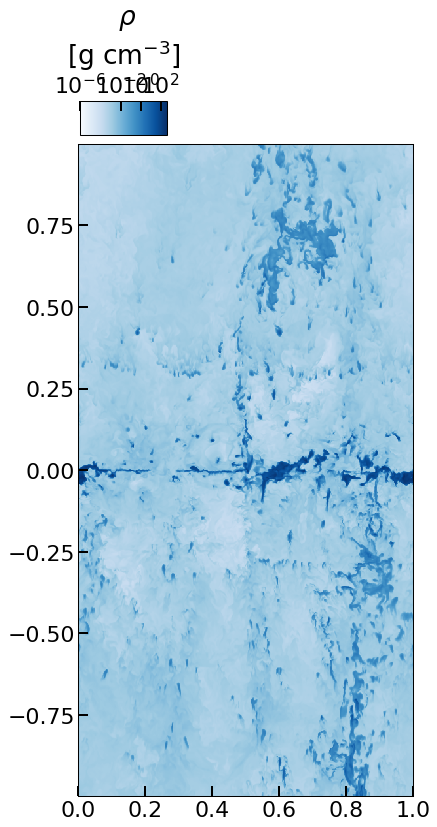

In [23]:
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(6, 12))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.2
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5
plane = (int)(ncells[1]/2)
# plane = 47

plot = ax.pcolormesh(xrange/kpc,zrange[disk]/kpc, np.transpose(rho_gas[:,plane,disk]/mp),\
                    norm=mcolors.LogNorm(vmin=1.e-6, vmax=4.e2),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6,  1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[g cm$^{-3}$]")



In [4]:
file = '/g/data/jh2/av5889/quokka_myrepo/quokka/sims/N4Gpu/2pcNoAMR/Setonix/HiepData/reduce_data.h5'
hf = h5py.File(file ,'r')
rho = np.array(hf.get("Rho")) 
zarr = np.array(hf.get("Z"))
xarr = np.array(hf.get("X"))
hf.close()

/jobfs/114159402.gadi-pbs/ipykernel_309003/2508555688.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = ax.pcolormesh(xarr/kpc,zarr/kpc, np.transpose(rho[:,plane,:]/mp),\


Text(0, 0.5, 'z [kpc]')

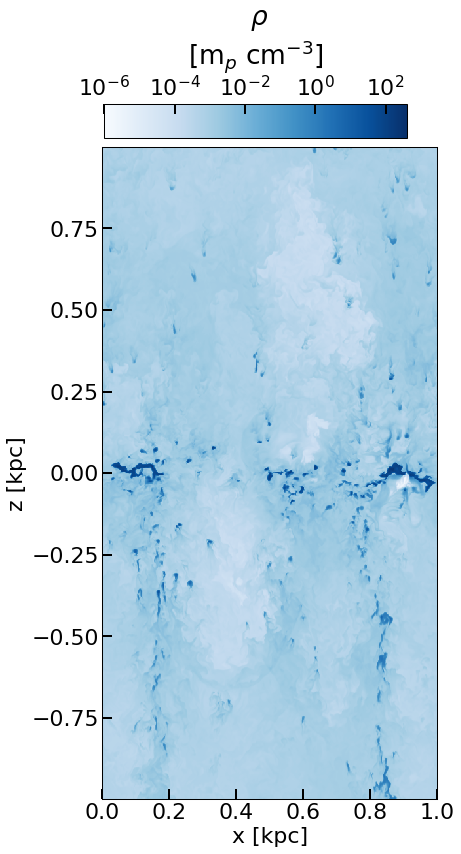

In [14]:
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.02},figsize=(6, 12))
i=0

cbarx = 0.13
cbheight = 0.04
cbary = 0.89
cblen = 0.7
dx1 = 0.25
cbtitlex = 0.1
cbtitley = 16.5
# plane = (int)(ncells[1]/2)
plane = 47

plot = ax.pcolormesh(xarr/kpc,zarr/kpc, np.transpose(rho[:,plane,:]/mp),\
                    norm=mcolors.LogNorm(vmin=1.e-6, vmax=4.e2),
                    cmap='Blues')
cax = fig.add_axes([cbarx, cbary, cblen, cbheight])
fig.colorbar(plot, cax=cax, orientation='horizontal', ticks=(1.e-6, 1.e-4, 1.e-2, 1., 1.e2))
cax.xaxis.set_ticks_position('top')
cax.set_title(r" $\rho$" + "\n" + "[m$_p$ cm$^{-3}$]")

ax.set_xlabel('x [kpc]')
ax.set_ylabel('z [kpc]')